# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [144]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [145]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [146]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(62, 6)


,title,price,year,link,brand,age
0,1997 honda accord lx 2 door,2800,1997.0,https://charlottesville.craigslist.org/cto/d/c...,honda,28.0
1,2004 toyota tundra sr5 for sale - manual tran...,6500,2004.0,https://charlottesville.craigslist.org/cto/d/a...,toyota,21.0
2,"2006 cadillac cts 107,086 miles only",2950,2006.0,https://charlottesville.craigslist.org/cto/d/c...,cadillac,19.0
3,chevy,6000,NaN,https://charlottesville.craigslist.org/cto/d/w...,chevy,NaN
4,1966 chevrolet corvair corsa sport coupe,5000,1966.0,https://charlottesville.craigslist.org/cto/d/b...,chevrolet,59.0


With the data in and wrangled, we can now do some analysis:

count       62.000000
mean      9587.887097
std      10731.142518
min       2000.000000
25%       3412.500000
50%       6375.000000
75%      10887.500000
max      62800.000000
Name: price, dtype: float64


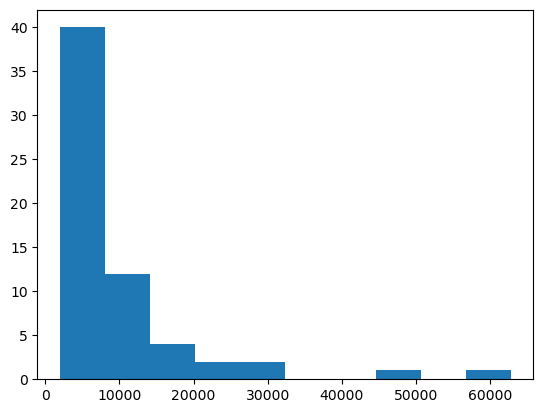

count    57.000000
mean     22.140351
std      14.575467
min       4.000000
25%      13.000000
50%      18.000000
75%      24.000000
max      68.000000
Name: age, dtype: float64


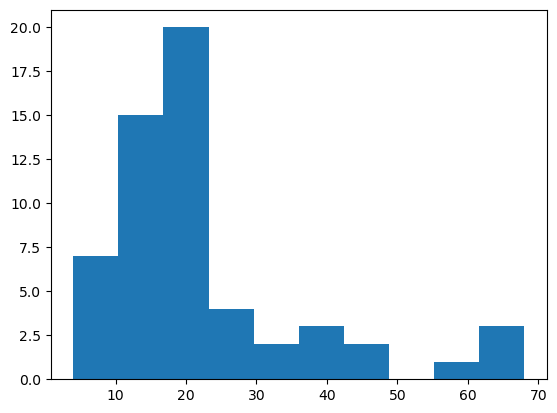

In [147]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [148]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    2.0   9750.000000   6717.514421   5000.0   7375.0   9750.0   
chevy        3.0   3966.666667   1761.628035   2900.0   2950.0   3000.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         7.0  17142.857143  15258.096992   4000.0   8250.0  13500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda       10.0   9020.000000   8044.017791   2800.0   3725.0   6200.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
missing     15.0   8759.933333  15883.759723   2000.0   3050.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   8280.000000   5147.523676   3000.0   5200.0   6500.0   
volkswagen   2.0   4550.000000   2757.716447   2600.0   3575.0   4550.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw          9375.0  10000.0  
cadillac     2950.0   2950.0  
chevrolet   12125.0  14500.0  
chevy        4500.0   6000.0  
dodge        8312.5   9750.0  
ford        18250.0  49500.0  
gmc         21250.0  26000.0  
honda       11725.0  29000.0  
jeep         8725.0   8750.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
missing      4499.5  62800.0  
mitsubishi   6800.0   6800.0  
tesla       26900.0  26900.0  
toyota      10700.0  16000.0  
volkswagen   5525.0   6500.0

In [149]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    2.0  47.500000  16.263456  36.0  41.75  47.5  53.25  59.0
chevy        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         7.0  18.000000   8.485281   8.0  12.00  17.0  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda       10.0  14.100000   6.471304   4.0  11.25  14.0  15.75  28.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     13.0  31.923077  21.398838   7.0  18.00  24.0  46.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  19.200000   4.919350  12.0  17.00  21.0  21.00  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.50  44.0

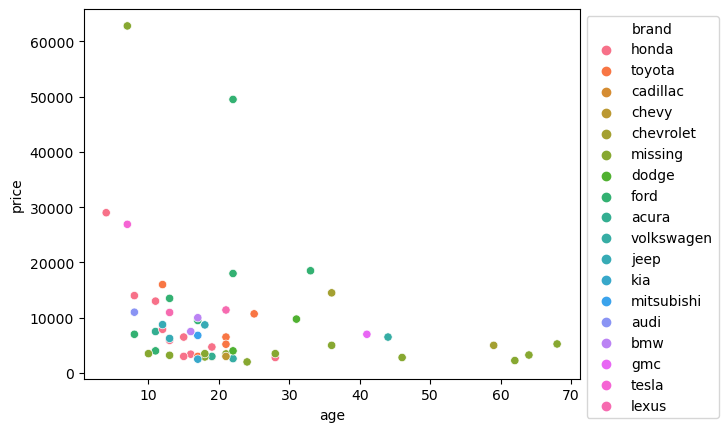

In [150]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.626000 -0.181308
log_age    -0.181308  0.345214
           log_price   log_age
log_price   1.000000 -0.397748
log_age    -0.397748  1.000000


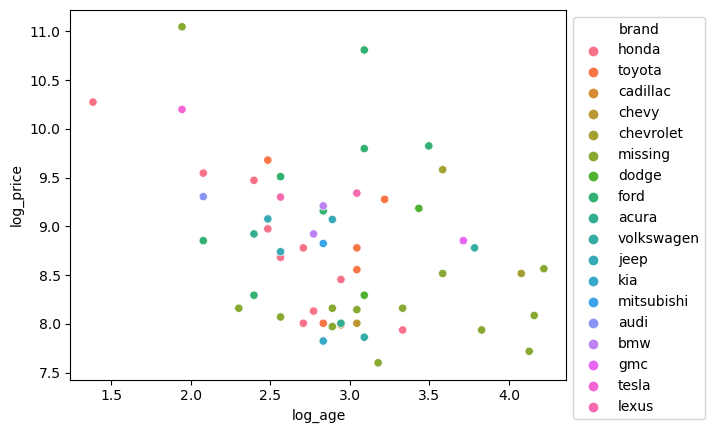

In [151]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [152]:
# Part 1 and 2

# Furniture on craigslist
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/fua#search=1~gallery~0~0' # furniture url
raw = requests.get(url,headers=header) # Get page

from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

I will gather data from the title, and specifically filter for specific types of furniture, like (shelf, cabinet, table, etc). 
I will gather information on the price. 
I will also try to filter for the type of material, like glass, wood, ceramic, from the title.
I will get the location.
The basic EDA I will do is using .describe to see the summary information for the data. 
I will also try to compare variables with each other using value counts.
I will also make a few basic plots to show frequencies within variables or show the relationship between variables. 

In [153]:
import re # Regular expressions

types = ["table", "chair", "desk", "stool", "cabinet", "art", "bed", "sofa", "rack", 
         "ottoman", "headboard", "mattress", "bookcase", "shelf", "dining table", "armchair", 
         "bed frame", "tv stand", "vanity", "recliner", "closet", "dresser"]


materials = ["wood", "glass", "leather", "iron", "brass", "wicker", "bamboo", 
             "ceramic", "steel", "velvet", "marble", "faux leather", "concrete", "copper"]

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']

    location_tag = listings[k].find('div', class_='location')
    location = location_tag.get_text(strip=True) if location_tag else "unknown"

    # Get furniture type from the title string:
    words = title.split()
    hits = [word for word in words if word in types] # Find furniture types in the title
    if len(hits) == 0:
        type = np.nan
    else:
        type = hits[0]
    
    # Get material type from the title string:
    words = title.split()
    hits = [word for word in words if word in materials] # Find material types in the title
    if len(hits) == 0:
        material = np.nan
    else:
        material = hits[0]

    data.append({'title':title,'price':price,'type':type, 'material':material, 'location':location, 'link':link})


In [154]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')

print(df.shape)
df.to_csv('./src/craigslist_cville_furniture.csv') # Save data in case of a disaster
df.head()

(356, 6)


,title,price,type,material,location,link
0,lazy boy recliner/rocker,1000,NaN,NaN,unknown,https://charlottesville.craigslist.org/fuo/d/r...
1,shelf,50,shelf,NaN,Zioncross Roads,https://charlottesville.craigslist.org/fuo/d/m...
2,complete kitchen cabinet set with sink and mic...,300,cabinet,NaN,"Gordonsville, Va.",https://charlottesville.craigslist.org/fuo/d/s...
3,entertainment cabinet,125,cabinet,NaN,Palmyra,https://charlottesville.craigslist.org/fuo/d/p...
4,unique bookends wine rack,20,rack,NaN,Charlottesville,https://charlottesville.craigslist.org/fuo/d/c...


count     356.000000
mean      168.398876
std       325.291494
min         0.000000
25%        30.000000
50%        75.000000
75%       166.000000
max      2800.000000
Name: price, dtype: float64


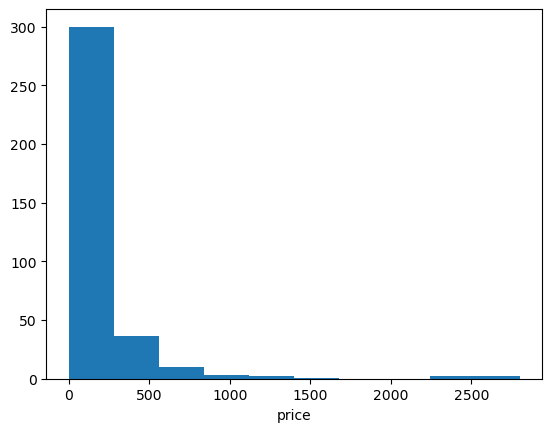

count       182
unique       19
top       table
freq         63
Name: type, dtype: object


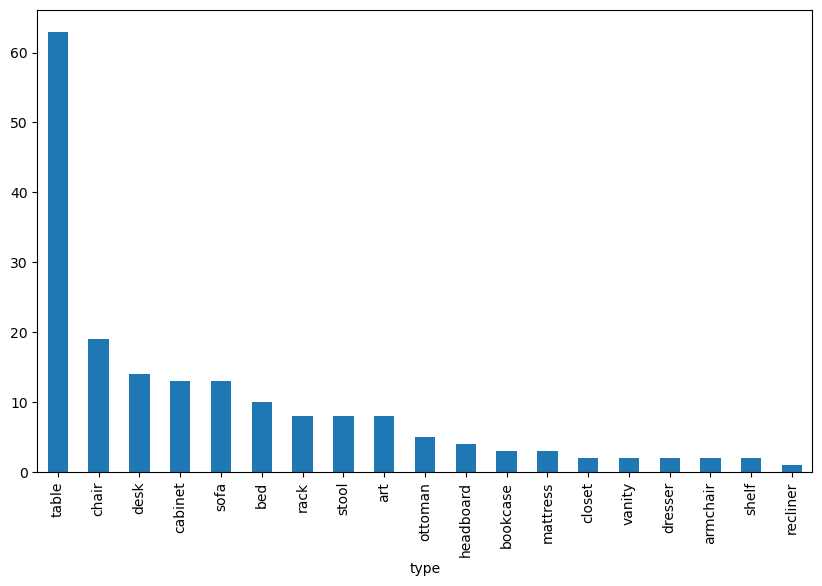

In [155]:
# Histogram of price
print(df['price'].describe())
df['price'].hist(grid=False)
plt.xlabel('price')
plt.show()

# Bar chart of furniture type
print(df['type'].describe())
plt.figure(figsize=(10, 6))
df['type'].value_counts().plot(kind='bar', grid=False)
plt.show()

In [156]:
# relationship of furniture type and price
# we can see what furniture type is the most expensive
df.loc[:, ['price', 'type']].groupby('type').describe().sort_values(by=('price', 'mean'), ascending=False)


price                                                          \
          count        mean          std    min     25%    50%      75%   
type                                                                      
mattress    3.0  883.333333  1400.074403   75.0   75.00   75.0  1287.50   
sofa       13.0  473.846154   463.600734   40.0  150.00  250.0   750.00   
bed        10.0  444.500000   779.360315   10.0   67.50  122.5   300.00   
armchair    2.0  400.000000   424.264069  100.0  250.00  400.0   550.00   
table      63.0  202.333333   469.421882   10.0   40.00   75.0   162.00   
dresser     2.0  185.000000    84.852814  125.0  155.00  185.0   215.00   
vanity      2.0  115.000000   120.208153   30.0   72.50  115.0   157.50   
cabinet    13.0  114.384615   121.032736    1.0   15.00   45.0   200.00   
art         8.0  102.500000    51.892747   20.0   75.00   87.5   150.00   
chair      19.0  101.315789   119.056967   10.0   20.00   50.0   150.00   
stool       8.0   88.750000   138.634927   10.0   15.00   47.5    75.00   
desk       14.0   78.428571    64.155717   10.0   36.25   67.5    96.50   
shelf       2.0   64.500000    20.506097   50.0   57.25   64.5    71.75   
closet      2.0   50.000000    35.355339   25.0   37.50   50.0    62.50   
headboard   4.0   43.750000    25.289985   15.0   26.25   47.5    65.00   
ottoman     5.0   42.000000    33.466401   20.0   20.00   30.0    40.00   
recliner    1.0   40.000000          NaN   40.0   40.00   40.0    40.00   
rack        8.0   25.250000     9.632534   10.0   18.75   28.5    30.00   
bookcase    3.0   23.333333    11.547005   10.0   20.00   30.0    30.00   

                   
              max  
type               
mattress   2500.0  
sofa       1500.0  
bed        2500.0  
armchair    700.0  
table      2800.0  
dresser     245.0  
vanity      200.0  
cabinet     300.0  
art         175.0  
chair       400.0  
stool       425.0  
desk        250.0  
shelf        79.0  
closet       75.0  
headboard    65.0  
ottoman     100.0  
recliner     40.0  
rack         40.0  
bookcase     30.0

In [157]:
# relationship of furniture material and price
# we can see what furniture material is the most expensive
df.loc[:, ['price', 'material']].groupby('material').describe().sort_values(by=('price', 'mean'), ascending=False)

price                                                               
         count        mean         std    min     25%    50%      75%     max
material                                                                     
leather    6.0  691.666667  552.645154  150.0  312.50  500.0  1062.50  1500.0
velvet     2.0  575.000000  247.487373  400.0  487.50  575.0   662.50   750.0
marble     2.0  323.500000  383.958982   52.0  187.75  323.5   459.25   595.0
iron       4.0  145.000000  146.401275   30.0   45.00  100.0   200.00   350.0
wood      24.0   87.458333  104.477158   10.0   27.50   37.5    93.75   375.0
copper     1.0   78.000000         NaN   78.0   78.00   78.0    78.00    78.0
glass     18.0   63.777778   43.605930    5.0   30.00   59.5    75.00   150.0
brass      3.0   63.333333   32.532035   30.0   47.50   65.0    80.00    95.0
wicker     4.0   54.750000   39.584298   15.0   25.50   52.0    81.25   100.0
concrete   1.0   50.000000         NaN   50.0   50.00   50.0    50.00    50.0
bamboo     3.0   38.333333   20.816660   15.0   30.00   45.0    50.00    55.0
ceramic    2.0   25.000000    7.071068   20.0   22.50   25.0    27.50    30.0

In [158]:
# Relationship between material type and furniture type
df.groupby(['type', 'material']).size().unstack(fill_value=0)


material,glass,wood,wicker,brass,leather,velvet,bamboo,ceramic,concrete,iron,marble
type,,,,,,,,,,,
art,1,0,0,0,0,0,0,0,0,0,0
cabinet,1,2,0,0,0,0,0,0,0,0,0
chair,0,3,1,0,0,0,0,0,0,0,0
desk,0,3,0,0,0,0,0,0,0,0,0
headboard,0,0,1,1,0,0,0,0,0,0,0
rack,1,0,1,0,0,0,0,0,0,0,0
sofa,0,0,0,0,3,1,0,0,0,0,0
stool,0,0,0,0,0,0,1,0,0,0,0
table,7,11,0,0,0,0,0,1,1,2,1


In [159]:
# I noticed that even though this was a Charlottesville search, not all locations were in Charlottesville
df.value_counts(df['location'])

location
Charlottesville                                       86
unknown                                               52
PALMYRA                                               42
Louisa                                                24
Palmyra                                               21
SCOTTSVILLE                                           18
Lexington                                             12
Orange                                                 9
charlottesville                                        7
Woodbrook neighborhood                                 6
Earlysville                                            5
Gordonsville, Va.                                      5
Bremo Bluff                                            4
Forest Lakes                                           4
Pantops                                                4
Troy                                                   4
Crozet                                                 4
CROZET                

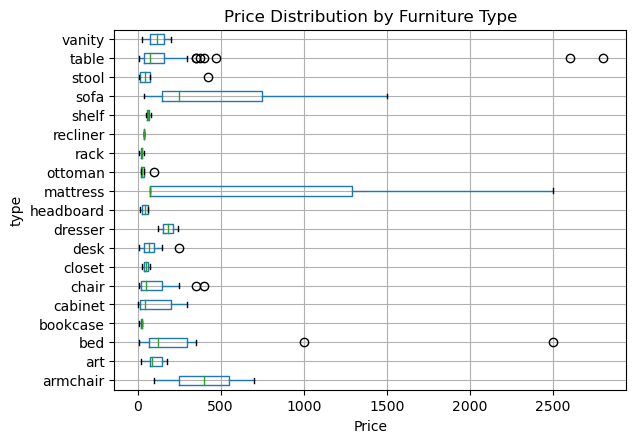

In [160]:
# plot to show the relationship between furniture type and price

df.boxplot(column='price', by='type', vert=False)
plt.title('Price Distribution by Furniture Type')
plt.suptitle('')
plt.xlabel('Price')
plt.show()


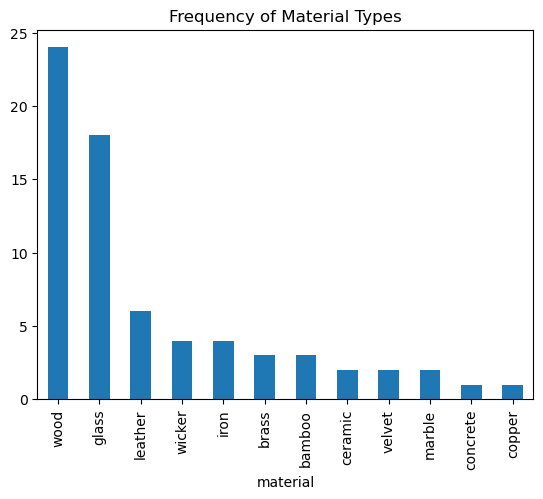

In [161]:
material_counts = df['material'].value_counts()
material_counts.plot(kind='bar')
plt.title('Frequency of Material Types')
plt.show()

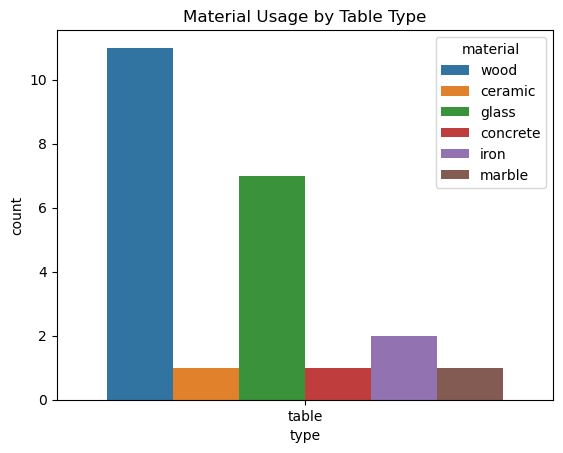

In [162]:
# Filter data to only include tables
table_data = df[df['type'] == 'table']

# Plot to show material type within tables
sns.countplot(x='type', hue='material', data=table_data)
plt.title('Material Usage by Table Type')
plt.show()